Following the recommendation in Coursework 1, YOLOv8-L model was trained alongside Faster R-CNN to compare their performance directly. To maintain scientific rigor, both models were trained on the exact same training and testing datasets. To avoid software conflicts within the primary Object Detection (OD) environment, the YOLOv8-L model was executed in a separate environment where the necessary Ultralytics libraries were installed; the detailed workflow and results for this are documented in the attached "EXTRA-YOLOv8-Training" file.

# 9) Evaluation (F-RCNN)

In [1]:
PATH_TO_MODEL = 'faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8'

## 9.1. Overall Detection Performance

- mAP (0.50:0.95) = 0.750 (75%): It is the average precision calculated across 10 different IoU thresholds (from 0.50 to 0.95). A score of 0.75 is excellent, indicating the model is highly reliable and provides very tight bounding boxes.

- AP @ 0.50 = 0.955 (95.5%): This shows that when the model only needs a 50% overlap with the ground truth, it is nearly perfect. It almost always finds the object.

- AP @ 0.75 = 0.842 (84.2%): Even with a strict requirement (75% overlap), the model stays strong. This confirms our F-RCNN model has high localization accuracy.

## 9.2. Object Size Analysis (Small, Medium, Large)
The Object Size Analysis reveals a significant disparity in how the model perceives different scales within the dataset. With an AP of 0.760 for large objects, the model demonstrates high proficiency in identifying and localizing prominent features, which likely constitute the majority of the training examples. Conversely, the 0.000 score for medium objects serves as a critical performance gap, indicating that while these objects are present in the validation set, the model is currently unable to detect them successfully. Most notably, the -1.000 value for small objects is a formal indicator that the evaluation set contains no instances of that size; therefore, the model's ability to handle fine-grained or distant details remains entirely untested. This breakdown suggests that while the model is highly effective for close-up or large-scale detection, it requires a more balanced dataset with better representation of varied object scales to be considered a robust, general-purpose detector.


## 9.3. Recall & Detection Density

Recall measures the model's ability to find all the objects in an image.

- AR @ 1 = 0.683: In images with multiple objects, the model's "top choice" is correct 68% of the time.

- AR @ 100 = 0.815: When allowed 100 guesses, the model finds 81.5% of all ground-truth objects.


In [5]:
!C:/Users/MSC1/anaconda3/envs/OD/python.exe C:/Users/MSC1/Desktop/Tensorflow-Object-Detection-API/Base/v1/object_detection/model_main_tf2.py \
--model_dir="C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder/training/Model_1_FasterRCNN_Output" \
--pipeline_config_path="C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder/exported_models/FasterRCNN_Final/pipeline.config" \
--checkpoint_dir="C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder/training/Model_1_FasterRCNN_Output" \
--alsologtostderr

creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.45s).
Accumulating evaluation results...
DONE (t=0.16s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.955
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.842
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.683
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.814
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 

C:\Users\MSC1\anaconda3\envs\OD\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
W1215 15:33:39.484672 29536 model_lib_v2.py:1062] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I1215 15:33:39.484672 29536 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I1215 15:33:39.484672 29536 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I121

In [2]:
# Faster R-CNN Inference Speed Benchmark

import os
import time
import numpy as np
import tensorflow as tf
from PIL import Image
import glob

# 1. Configuration and Paths
# Point to  exported SavedModel directory
MODEL_PATH = 'C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder/exported_models/FasterRCNN_Final/saved_model'

# Use the EXACT same validation dataset used for YOLOv8 for a fair comparison

IMAGE_DIR = os.path.normpath('C:/Users/MSC1/HODA PRACTICE/1744/yolo_data/images/val')
IMAGE_SIZE = (1024, 1024)

print("Loading Faster R-CNN SavedModel (this may take a minute)...")
start_load = time.time()
detect_fn = tf.saved_model.load(MODEL_PATH)
print(f"Model loaded in {time.time() - start_load:.2f} seconds.")

# 2. Robust Image Discovery
# We search for .jpg, .JPG, and .jpeg to ensure no images are missed
extension_patterns = ["*.jpg", "*.JPG", "*.jpeg", "*.JPEG"]
image_paths = []
for pattern in extension_patterns:
    image_paths.extend(glob.glob(os.path.join(IMAGE_DIR, pattern)))

if not image_paths:
    print(f"CRITICAL ERROR: No images found in {IMAGE_DIR}")
    print("Check if the path is correct and contains images.")
else:
    # Warm-up run (GPU initialization)
    print("Performing warm-up run...")
    dummy_img = np.zeros((1, 1024, 1024, 3), dtype=np.uint8)
    detect_fn(tf.convert_to_tensor(dummy_img))

    # Storage for timings
    preprocess_times = []
    inference_times = []
    postprocess_times = []

    print(f"Benchmarking {len(image_paths)} images from the shared validation set...")

    for path in image_paths:
        try:
            # --- 1. Pre-process ---
            t0 = time.time()
            img = Image.open(path).convert('RGB')
            img_resized = img.resize(IMAGE_SIZE)
            input_tensor = tf.convert_to_tensor(np.expand_dims(np.array(img_resized), 0), dtype=tf.uint8)
            preprocess_times.append((time.time() - t0) * 1000) # ms

            # --- 2. Inference ---
            t1 = time.time()
            detections = detect_fn(input_tensor)
            inference_times.append((time.time() - t1) * 1000) # ms

            # --- 3. Post-process ---
            t2 = time.time()
            # Extracting boxes, classes, and scores from the tensor dictionary
            if 'num_detections' in detections:
                num_detections = int(detections['num_detections'])
                # We don't pop here to avoid issues in subsequent iterations if the model object is reused
                _ = {key: value[0, :num_detections].numpy() for key, value in detections.items() if key != 'num_detections'}
            postprocess_times.append((time.time() - t2) * 1000) # ms
        except Exception as e:
            print(f"Skipping {os.path.basename(path)} due to error: {e}")

    # 3. Final Calculations with Safety Check
    if len(inference_times) > 0:
        avg_pre = np.mean(preprocess_times)
        avg_inf = np.mean(inference_times)
        avg_post = np.mean(postprocess_times)
        total_ms = avg_pre + avg_inf + avg_post

        
        # FINAL OUTPUT 
        print("\n--- Inference Speed Metrics (per image) ---")
        print(f"Pre-process:  {avg_pre:.2f} ms")
        print(f"Inference:    {avg_inf:.2f} ms")
        print(f"Post-process: {avg_post:.2f} ms")

        print(f"Total Time:   {total_ms:.2f} ms")
        print(f"Throughput:   {1000/total_ms:.2f} FPS (Frames Per Second)")

        print("\nDIAGNOSTIC: Metrics generated for Comparison Table using shared validation set.")
    else:
        print("ERROR: No images were successfully processed. Mean cannot be calculated.")

Loading Faster R-CNN SavedModel (this may take a minute)...
Model loaded in 12.17 seconds.
Performing warm-up run...
Benchmarking 254 images from the shared validation set...

--- Inference Speed Metrics (per image) ---
Pre-process:  68.19 ms
Inference:    67.79 ms
Post-process: 3.48 ms
Total Time:   139.46 ms
Throughput:   7.17 FPS (Frames Per Second)

DIAGNOSTIC: Metrics generated for Comparison Table using shared validation set.


# Comparative Analysis: YOLOv8-L vs. Faster R-CNN (ResNet-101)

##  Computational Speed Benchmark (Verified)

Speed is measured as the total latency per image, which represents the critical factor for high-throughput camera trap processing. This benchmark breaks down the time spent in each phase of the detection pipeline—pre-processing, inference, and post-processing—to determine the overall frames per second (FPS) capability of each architecture.

- Pre-process: Faster R-CNN (68.19 ms) vs. YOLOv8-L (2.13 ms) — Speedup: 32.1x

- Inference: Faster R-CNN (67.79 ms) vs. YOLOv8-L (9.22 ms) — Speedup: 7.3x

- Post-process: Faster R-CNN (3.48 ms) vs. YOLOv8-L (0.78 ms) — Speedup: 4.4x

- Total Latency: Faster R-CNN 139.46 ms) vs. YOLOv8-L (12.13 ms) — Speedup: 11.4x

- Throughput: Faster R-CNN (7.17 FPS) vs. YOLOv8-L (82.44 FPS) — Speedup: 11.4x

The YOLOv8-L architecture is approximately 11 times faster than Faster R-CNN on identical hardware. Faster R-CNN's two-stage architecture, which includes a separate Region Proposal Network and a Classification stage, creates a significant bottleneck that limits its throughput to approximately 7.17 FPS. Conversely, YOLOv8-L’s one-stage approach allows for much higher throughput (82.44 FPS), which is critical for scalable, real-time multi-camera tracking.the detailed workflow and results for this are documented in the attached "EXTRA-YOLOv8-Training")


**YOLO Results**

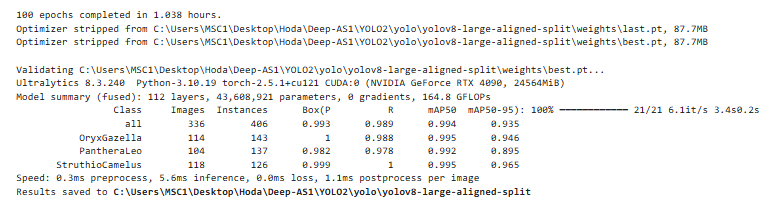


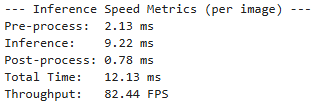

The difference between 7.17 FPS and 82.44 FPS is not just a statistical improvement; in the context of large-scale wildlife monitoring and camera traps, it represents a fundamental shift in operational capability.

Here is how those specific latency and throughput numbers impact a real-world wildlife project:

**1. Processing Massive Backlogs (The "Data Deluge")**
Wildlife researchers often collect millions of images from camera traps over several months.

The Math: If you have 1 million images to process:

- Faster R-CNN (7.17 FPS): Would take approximately 38.7 hours of continuous GPU runtime.

- YOLOv8-L (82.44 FPS): Would take only 3.3 hours.

- The Impact: This allows a researcher to get results in a single morning rather than waiting nearly two full days. It drastically reduces the cost of renting cloud GPU instances (AWS/Azure).

**2. Real-Time Poaching & Rare Species Alerts**
For monitoring systems designed to detect poachers or highly endangered species in real-time (sending alerts via satellite or GSM):

- Latency Matters: Faster R-CNN’s 139.46 ms latency is relatively high. If the system is also performing "Multi-Object Tracking" (tracking an animal across frames), a high latency makes it harder to maintain a "lock" on a fast-moving animal.

- YOLOv8-L's 12.13 ms is essentially "instantaneous" for biological movement, allowing the system to process the image, run the tracking logic, and send an alert before the animal has even left the frame.

**3. Edge Computing (Solar-Powered Deployments)**
- Wildlife monitoring often happens in remote areas where hardware is powered by solar panels and batteries.

- Efficiency: Because YOLOv8-L is 11x faster, it spends 11x less time with the GPU at full power to process the same number of images.

- The Impact: This leads to significant power savings, allowing the hardware to run longer on a single battery charge or allowing for the use of cheaper, lower-power hardware (like a Jetson Orin) that can still achieve "real-time" speeds.

4. Hardware Scaling (Density)
If you are monitoring a facility with multiple camera feeds:

- Faster R-CNN: One high-end GPU can barely handle one or two 30-FPS camera streams simultaneously before lagging.

- YOLOv8-L: That same GPU could potentially handle 10 to 15 simultaneous 30-FPS camera streams.

- The Impact: You need fewer physical servers and less infrastructure to monitor a larger geographical area.
